第0次遍历整个数据集，当前误差：0.6905522446113365
第1000次遍历整个数据集，当前误差：0.18550136438550568
第2000次遍历整个数据集，当前误差：0.15083046575253206
第3000次遍历整个数据集，当前误差：0.07445438570997179
第4000次遍历整个数据集，当前误差：0.1259591565133716
第5000次遍历整个数据集，当前误差：0.10434443534245477
第6000次遍历整个数据集，当前误差：0.10067637504120648
第7000次遍历整个数据集，当前误差：0.03165203013511564
第8000次遍历整个数据集，当前误差：0.11197273131244206
第9000次遍历整个数据集，当前误差：0.19794007152465484


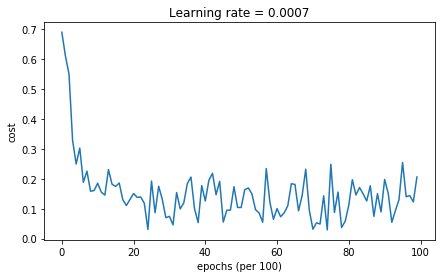

Accuracy: 0.94


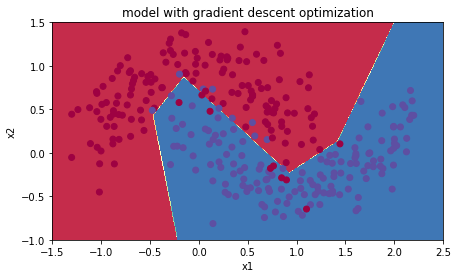

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

import opt_utils
import testCase

plt.rcParams['figure.figsize'] = (7.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def update_parameters_with_gd(parameters , grads , learning_rate):
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads['dW' + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads['db' + str(l + 1)]
    
    return parameters

def random_mini_batches(X,Y,mini_batch_size = 64,seed = 0):
    np.random.seed(seed);
    m = X.shape[1]
    mini_batchs = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation].reshape((1,m))
    
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:,mini_batch_size * k : mini_batch_size * (k+1)]
        mini_batch_Y = shuffled_Y[:,mini_batch_size * k : mini_batch_size * (k+1)]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batchs.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,mini_batch_size * num_complete_minibatches :]
        mini_batch_Y = shuffled_Y[:,mini_batch_size * num_complete_minibatches :]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batchs.append(mini_batch)
    
    return mini_batchs

def initialize_velocity(parameters):
    L = len(parameters) // 2
    v = {}
    
    for l in range(L):
        v['dW' + str(l + 1)] = np.zeros_like(parameters['W' + str(l + 1)])
        v['db' + str(l + 1)] = np.zeros_like(parameters['b' + str(l + 1)])
    
    return v

def update_parameters_with_momentun(parameters,grads,v,beta,learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        v['dW' + str(l + 1)] = beta * v['dW' + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
        v['db' + str(l + 1)] = beta * v['db' + str(l + 1)] + (1 - beta) * grads['db' + str(l + 1)]
    
        parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * v['dW' + str(l + 1)]
        parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * v['db' + str(l + 1)]
    
    return parameters,v

def initialize_adam(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v['dW' + str(l + 1)] = np.zeros_like(parameters['W' + str(l + 1)])
        v['db' + str(l + 1)] = np.zeros_like(parameters['b' + str(l + 1)])
        
        s['dW' + str(l + 1)] = np.zeros_like(parameters['W' + str(l + 1)])
        s['db' + str(l + 1)] = np.zeros_like(parameters['b' + str(l + 1)])
    return (v,s)

def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate = 0.01,beta1 = 0.9,beta2 = 0.999 ,epsilon = 1e-8):
    L = len(parameters) // 2
    s_corrected = {}
    v_corrected = {}
    
    for l in range(L):
        v['dW' + str(l + 1)] = beta1 * v['dW' + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v['db' + str(l + 1)] = beta1 * v['db' + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        
        v_corrected['dW' + str(l + 1)] = v['dW' + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected['db' + str(l + 1)] = v['db' + str(l + 1)] / (1 - np.power(beta1,t))
        
        s['dW' + str(l + 1)] = beta2 * s['dW' + str(l + 1)] + (1 - beta2) * np.square(grads['dW' + str(l + 1)])
        s['db' + str(l + 1)] = beta2 * s['db' + str(l + 1)] + (1 - beta2) * np.square(grads['db' + str(l + 1)])
        
        s_corrected['dW' + str(l + 1)] = s['dW' + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected['db' + str(l + 1)] = s['db' + str(l + 1)] / (1 - np.power(beta2,t))
         
        parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * v_corrected['dW' + str(l + 1)] / np.sqrt(s_corrected['dW' + str(l + 1)] + epsilon)
        parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * v_corrected['db' + str(l + 1)] / np.sqrt(s_corrected['db' + str(l + 1)] + epsilon)
    
    return (parameters,v,s)
train_x,train_y = opt_utils.load_dataset(is_plot = False)
def model(X,Y,layers_dims,optimizer,learning_rate = 0.0007,mini_batch_size = 64,beta = 0.9,beta1 = 0.9,beta2 = 0.999,epsilon = 1e-8,
         num_epochs = 10000,print_cost = True , is_plot = True):
    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    parameters = opt_utils.initialize_parameters(layers_dims)
    
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        v = initialize_velocity(parameters)
    elif optimizer == 'adam':
        v,s = initialize_adam(parameters)
    else:
        print('optimizer参数输入错误，程序退出。')
        exit(1)
    
    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X,Y,mini_batch_size,seed)
        
        for minibatch in minibatches:
            (minibatchX,minibatchY) = minibatch
            
            A3 ,cache = opt_utils.forward_propagation(minibatchX , parameters)
            
            cost = opt_utils.compute_cost(A3 , minibatchY)
            
            grads = opt_utils.backward_propagation(minibatchX,minibatchY,cache)
            
            if optimizer == 'gd':
                parameters = update_parameters_with_gd(parameters,grads,learning_rate)
            elif optimizer == 'momentum':
                parameters , v = update_parameters_with_momentun(parameters,grads,v,beta,learning_rate)
            elif optimizer == 'adam':
                t = t + 1
                parameters , v , s = update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
                
        
        if i % 100 == 0 :
            costs.append(cost)
            if print_cost and i % 1000 == 0 :
                print("第" + str(i) +'次遍历整个数据集，当前误差：' + str(cost))
    
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (per 100)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
    
    return parameters

layers_dims = [train_x.shape[0],5,2,1]
parameters = model(train_x, train_y, layers_dims, optimizer="adam",is_plot=True)  
predictions = opt_utils.predict(train_x,train_y,parameters)
plt.title("model with gradient descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])

opt_utils.plot_decision_boundary(lambda x : opt_utils.predict_dec(parameters,x.T) , train_x,train_y)